# Missing value Treatment

In [56]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

import scipy.stats as stats
from scipy.stats import zscore

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer,StandardScaler

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.metrics import classification_report,accuracy_score,precision_score,confusion_matrix
from sklearn.metrics import recall_score,f1_score,balanced_accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier

from sklearn.feature_selection import RFE,SelectKBest,SequentialFeatureSelector

from imblearn.over_sampling import SMOTE,SMOTEN,SMOTENC

import re

In [57]:
data = pd.read_csv('diabetic_data_original.csv')
admission_type = pd.read_excel('Mapping.xlsx',sheet_name='Admission_type_id')
discharge_disposition = pd.read_excel('Mapping.xlsx',sheet_name='Discharge_disposition')
admission_source = pd.read_excel('Mapping.xlsx',sheet_name='Admission_source_id')

In [58]:
df = data.copy()

In [59]:
mapping_1 = dict(zip(discharge_disposition.discharge_disposition_id.values,
                     discharge_disposition.description.values))
mapping_2 = dict(zip(admission_type.admission_type_id.values,admission_type.description.values))
mapping_3 = dict(zip(admission_source.admission_source_id.values,
                     admission_source.description.values))

In [60]:
df.discharge_disposition_id = df.discharge_disposition_id.map(mapping_1).astype('string')
df.admission_type_id = df.admission_type_id.map(mapping_2).astype('string')
df.admission_source_id = df.admission_source_id.map(mapping_3).astype('string')

In [61]:
df.isin(['?']).sum()[df.isin(['?']).sum() > 0]

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

In [62]:
df = df.replace(to_replace='?',value=np.nan)

In [63]:
df.isnull().sum()[df.isnull().sum() > 0]

race                         2273
weight                      98569
admission_type_id            5291
discharge_disposition_id     3691
admission_source_id          6781
payer_code                  40256
medical_specialty           49949
diag_1                         21
diag_2                        358
diag_3                       1423
dtype: int64

In [64]:
df = df.rename(columns={'diag_1':'diagnosis_1','diag_2':'diagnosis_2','diag_3':'diagnosis_3'})
df['readmitted'] = df.readmitted.map({'<30':'Yes','>30':'No',
                                      'NO':'No'})

### Transforming target variable to binary classification

In [65]:
def Tranform_target(x):
    if x == '<30':
        return 'Yes'
    else:
        return 'No'

In [66]:
patient_info = ['race', 'gender', 'age', 'admission_type_id',
                'discharge_disposition_id','admission_source_id',
                'medical_specialty','diagnosis_1','diagnosis_2', 'diagnosis_3',
                'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

# Features which contains no information
drop_list_patient_info = ['encounter_id','patient_nbr','weight','payer_code']

# Numeric features
patient_info_numeric = ['time_in_hospital','num_lab_procedures',
                        'num_procedures','num_medications',
                        'number_outpatient','number_emergency',
                        'number_inpatient','number_diagnoses']

# Taking initial decision to keep 16 features
feature_medicine = ['metformin','repaglinide', 'nateglinide', 
                     'chlorpropamide', 'glimepiride', 'glipizide', 
                     'glyburide', 'tolbutamide','pioglitazone',
                     'rosiglitazone', 'acarbose', 'miglitol','tolazamide',
                     'insulin','glyburide-metformin', 'glipizide-metformin']

# Initial decision to remove 7 features
drop_list_medicine = ['acetohexamide','troglitazone','examide','citoglipton',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']


# The medicines which contains 'Steady' & 'No' for encoding purpose
two_category_medicine = ['acetohexamide', 'tolbutamide', 'troglitazone',
                         'glipizide-metformin', 'glimepiride-pioglitazone',
                         'metformin-rosiglitazone', 'metformin-pioglitazone']
# ------------------------------------------------------------------
# The medicines which contains 'Steady','Up','Down' & 'No' for encoding purpose (14)
four_category_medicine = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                          'glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone',
                          'acarbose','miglitol','tolazamide','insulin','glyburide-metformin'] 
# ------------------------------------------------------------------
# considering these two medicines with only 'steady' & 'No' categories for encoding purpose
two_category_medicine_to_be_kept = ['tolbutamide','glipizide-metformin']
# ------------------------------------------------------------------                                                
# Out of initial removal decision, these 2 are compulsorily removed.
single_category_medicine = ['examide', 'citoglipton']
                                             

print(set(drop_list_medicine) & set(two_category_medicine))

dependent = 'readmitted'

{'metformin-pioglitazone', 'metformin-rosiglitazone', 'troglitazone', 'glimepiride-pioglitazone', 'acetohexamide'}


<a id="missing_treatment"></a>
## Missing value Treatment

In [67]:
df.isnull().sum()[df.isnull().sum()>0]

race                         2273
weight                      98569
admission_type_id            5291
discharge_disposition_id     3691
admission_source_id          6781
payer_code                  40256
medical_specialty           49949
diagnosis_1                    21
diagnosis_2                   358
diagnosis_3                  1423
dtype: int64

### a) RACE

In [68]:
# Patients who have visited multiple times

both_multiple_visit = list(df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() > 1].index)

# Patients who have not filled 'race' information & visited multiple times

race_multiple_but_null = df[(df['patient_nbr'].isin(both_multiple_visit)) & (df['race'].isnull())]
race_multiple_but_null_unique = race_multiple_but_null['patient_nbr'].unique()

# Patients who have filled 'race' information & visited multiple times

race_multiple_but_filled = df[(df['patient_nbr'].isin(both_multiple_visit)) & (df['race'].notna())]
race_multiple_but_filled_unique = race_multiple_but_filled['patient_nbr'].unique()

patients_imputation = [patient_nbr for patient_nbr in race_multiple_but_null_unique 
 if patient_nbr in race_multiple_but_filled_unique]

print("Patients who have not filled 'race' in one of the visits among multiple visits :",
     len(patients_imputation))

race_imputation_df = race_multiple_but_filled[race_multiple_but_filled['patient_nbr'].isin(patients_imputation)]
race_imputation_dict = race_imputation_df.set_index('patient_nbr')['race'].to_dict()

def bivariate_imputation(row,map_dict):
    if (pd.isna(row['race'])) and (row['patient_nbr'] in map_dict):
        row['race'] = map_dict[row['patient_nbr']]
    return row

# checking null values before imputation

print("Missing values before Imputation :",df['race'].isnull().sum())

# Filling 'Race' attribute through multiple visits of a particular_patient

df = df.apply(bivariate_imputation,axis=1,args=[race_imputation_dict])


# Checking null values after imputation

print("Missing values After Imputation :",df['race'].isnull().sum())

Patients who have not filled 'race' in one of the visits among multiple visits : 127
Missing values before Imputation : 2273
Missing values After Imputation : 2129


In [69]:
categories = df['race'].unique().tolist()

for feature in patient_info_numeric:
    annova = []
    for category in categories:
        annova.append(df[df['race'] == category][feature].values)
    p_value = stats.f_oneway(*annova)[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    print(f"{feature:25s} : {result}")
    annova = []

time_in_hospital          : Insignificant
num_lab_procedures        : Insignificant
num_procedures            : Insignificant
num_medications           : Insignificant
number_outpatient         : Insignificant
number_emergency          : Insignificant
number_inpatient          : Insignificant
number_diagnoses          : Insignificant


In [70]:
# with Annova we can say numerical columns are not significant with respect to Race
# Hence we will impute with 'Mode'

In [71]:
## but Since 'Caucasian' group is dominated in both the category
## We shall fill missing values using iterative Imputer 

### Case study on Diagnosis1,2 & 3

- Patients who have not filled 'diagnostics_1' information & visited multiple times
- taking those patient numbers and checking wheather the diagnosis were same during the subsequent visits ??

In [72]:
multiple_visit = both_multiple_visit

diag_1 = df[(df['patient_nbr'].isin(multiple_visit)) & 
            (df['diagnosis_1'].isnull())]['patient_nbr'].values

In [73]:
df[(df['patient_nbr'].isin(diag_1)) 
   & (df['diagnosis_1'].notna())][['patient_nbr','diagnosis_1',
                              'diagnosis_2','diagnosis_3']].sort_values(by=['patient_nbr']).head(8)

,patient_nbr,diagnosis_1,diagnosis_2,diagnosis_3
4643,916947,440,295,250.01
5332,4232736,428,425,250.6
5673,4232736,617,425,250
10509,4232736,276,425,428
1918,9946782,440,444,496
5676,18328716,250.02,707,823
28162,23460408,490,V42,427
15440,23460408,788,599,250


In [74]:
# from above Dataframe we can find out that during multiple visits
# patient's were diagnosed with different diagnosis compared to previous visits

- Patients who have not filled 'diagnostics_2' information & visited multiple times

In [75]:
diagnosis_2 = df[(df['patient_nbr'].isin(multiple_visit)) 
            & (df['diagnosis_2'].isnull())]['patient_nbr'].values

In [76]:
df[(df['patient_nbr'].isin(diagnosis_2)) 
   & (df['diagnosis_2'].notna())][['patient_nbr','diagnosis_1',
                              'diagnosis_2','diagnosis_3']].sort_values(by=['patient_nbr']).head(8)

,patient_nbr,diagnosis_1,diagnosis_2,diagnosis_3
26258,176607,440,414,401
27226,287640,250.13,276,NaN
19410,1386945,296,250.01,746
2653,1386945,250.13,276,NaN
14983,1473309,250.13,427,427
13880,1473309,250.6,536,337
9370,1473309,250.13,276,V15
22612,1473309,250.11,276,250.6


- Patients who have not filled 'diagnostics_3' information & visited multiple times

In [77]:
diagnosis_3 = df[(df['patient_nbr'].isin(multiple_visit)) 
            & (df['diagnosis_3'].isnull())]['patient_nbr'].values

In [78]:
df[(df['patient_nbr'].isin(diagnosis_3)) 
   & (df['diagnosis_3'].notna())][['patient_nbr','diagnosis_1',
                              'diagnosis_2','diagnosis_3']].sort_values(by=['patient_nbr']).head(8)

,patient_nbr,diagnosis_1,diagnosis_2,diagnosis_3
14180,1152,282,276,428
24642,1152,282,287,466
5953,1152,282,794,250
14289,24030,250.13,276,276
27478,40158,250.13,263,34
16944,40158,250.13,466,462
8186,40158,250.11,276,599
13470,40158,250.13,599,788


In [79]:
# From this we can say, patients on subsequent visits have different
# primary_diagnosis
# Secondary_diagnosis
# Additional_secondary_diagnosis

# So we decide not to fill missing values using this technique

## Feature Encoding 'Gender'

In [80]:
# Since there are very few category 'Unknown/Invalid' 
# we will replace it with 'mode'

df['gender'] = df['gender'].replace('Unknown/Invalid',df['gender'].mode()[0])

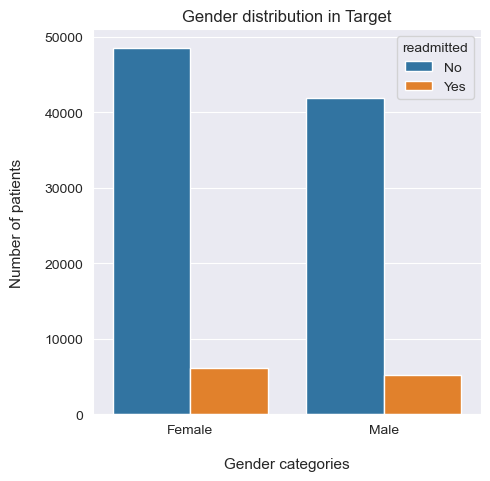

In [81]:
plt.subplots(figsize=(5,5))
sns.countplot(x=df['gender'],hue=df['readmitted'])
plt.title("Gender distribution in Target")
plt.xlabel("Gender categories",labelpad=15.0,fontsize=11)
plt.ylabel("Number of patients",labelpad=15.0,fontsize=11)
plt.show()

## Transforming feature 'Admission source'

In [82]:
def admission_source_encoding(x):
    if 'Referral' in str(x).split():
        return 'Referral'
    elif 'Emergency' in str(x).split():
        return 'Emergency'
    else:
        return 'other'
df.admission_source_id = df.admission_source_id.map(admission_source_encoding)

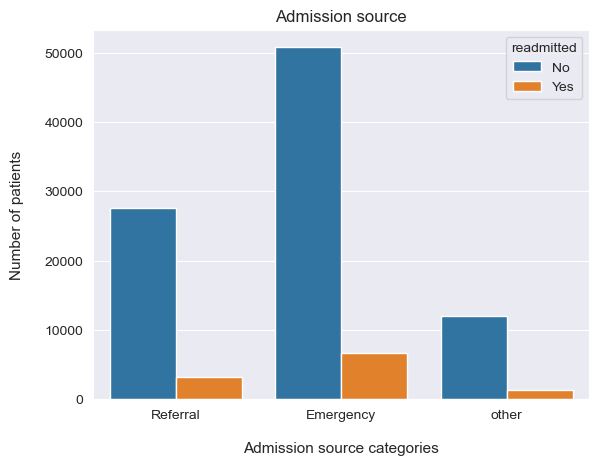

In [83]:
sns.countplot(x=df['admission_source_id'],hue=df['readmitted'])
plt.title("Admission source")
plt.xlabel("Admission source categories",labelpad=15.0,fontsize=11)
plt.ylabel("Number of patients",labelpad=15.0,fontsize=11)
plt.show()

In [84]:
df.admission_source_id.value_counts()

Emergency    57494
Referral     30856
other        13416
Name: admission_source_id, dtype: int64

## Transforming feature 'Admission type'

In [85]:
## We also have categorical variable in Admission_type_encoding
## That will be mapped to 'Other' category

In [86]:
df.admission_type_id.value_counts(dropna=False)

Emergency        53990
Elective         18869
Urgent           18480
<NA>              5291
Not Available     4785
Not Mapped         320
Trauma Center       21
Newborn             10
Name: admission_type_id, dtype: int64

In [87]:
df.admission_type_id.isnull().sum()

5291

In [88]:
df.loc[df.admission_type_id.isnull(),'admission_type_id'] = np.nan

## Transforming feature 'Admission type'

In [89]:
def admission_type_encoding(x):
    if pd.isna(x):
        return 'No mention'
    elif x in ['Not Available','Not Mapped','Trauma Center','Newborn']:
        return 'others'
    else:
        return x
df.admission_type_id = df.admission_type_id.map(admission_type_encoding)

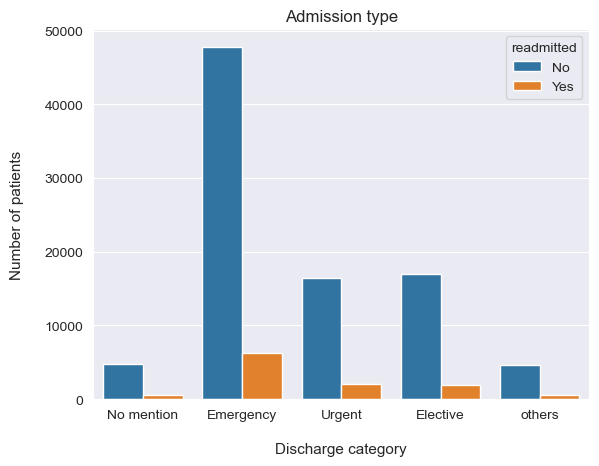

In [90]:
sns.countplot(x=df['admission_type_id'],hue=df['readmitted'])
plt.title("Admission type")
plt.xlabel("Discharge category",labelpad=15.0,fontsize=11)
plt.ylabel("Number of patients",labelpad=15.0,fontsize=11)
plt.show()

In [91]:
df.admission_type_id.value_counts()

Emergency     53990
Elective      18869
Urgent        18480
No mention     5291
others         5136
Name: admission_type_id, dtype: int64

## Transforming feature 'Discharge_disposition'

In [92]:
df.discharge_disposition_id.value_counts().count()

25

In [93]:
## Number of unique levels in Discharge disposition

print("The unique sub-category in Discharge disposition is :",
      len(df.discharge_disposition_id.unique()))

The unique sub-category in Discharge disposition is : 26


In [94]:
df.discharge_disposition_id = df.discharge_disposition_id.astype(str)

## Transforming feature 'Discharge_disposition'

In [95]:
def dishcharge_encoding(x):
    # let us remove patients who are transferred to 'Hospice' or 'expired'
    if ('hospice' in str(x).lower()) or ('Expired' in str(x).lower()):
        return np.nan
    elif 'discharged to home' in str(x).lower():
        return 'Discharge'
    elif 'transfer' in str(x).lower():
        return 'Transfer'
    else:
        return 'Other'
df.discharge_disposition_id = df.discharge_disposition_id.apply(dishcharge_encoding)

In [96]:
# Delete records which are from hospice, Expired

In [97]:
discharge_drop_index = df.discharge_disposition_id[df.discharge_disposition_id.isnull() == True].index

In [98]:
df = df.dropna(subset=['discharge_disposition_id'])

In [99]:
df = df.reset_index(drop=True)

In [100]:
df.shape

(100985, 50)

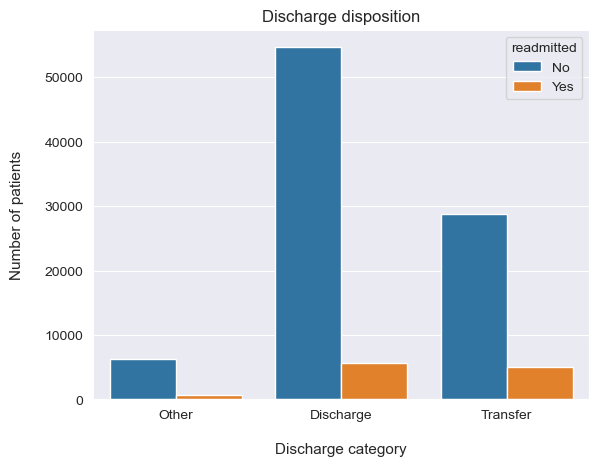

In [101]:
sns.countplot(x=df['discharge_disposition_id'],hue=df['readmitted'])
plt.title("Discharge disposition")
plt.xlabel("Discharge category",labelpad=15.0,fontsize=11.0)
plt.ylabel("Number of patients",labelpad=15.0,fontsize=11.0)
plt.show()

In [102]:
# Converting all strings to -1 to make attribute homogeneous
# Converting these columns to float64 datatype

diagnosis = ['diagnosis_1','diagnosis_2','diagnosis_3']
for diag in diagnosis:
    df[diag].loc[df[diag].astype('string').str.contains('[A-Za-z].+[0-9]*')] = -1
    df[diag] = df[diag].astype(np.float64)

In [103]:
def diagnosis_encoding(x):
    if pd.isna(x):
        return np.nan
    elif (x >= 140) and (x <= 239):
        return 'Neoplasms'
    elif x == 785 or (x >=390 and x <= 459):
        return 'circulatory'
    elif x == 786 or (x >= 460 and x <= 519):
        return 'Respiratory'
    elif x == 787 or (x >= 520 and x <= 579):
        return 'Digestive'
    elif x >= 250 and (x >= 250 and x <= 251):
        return 'Diabetes'
    elif x >= 800 and x <= 1000:
        return 'Injury'
    elif x >= 710 and x <= 739:
        return 'Musculoskeletal'
    elif (x >=580 and x <= 629) or x == 788: 
        return 'Genitourinary'
    elif x == -1:
        return 'other'
    else: 
        return 'other'

In [104]:
# Applying function to primary, secondary and Additional secondary columnnosis

diagnosis = ['diagnosis_1','diagnosis_2','diagnosis_3']

for column in diagnosis:
    df[column] = df[column].apply(diagnosis_encoding)

## Encoding feature 'Medical speciality'

In [106]:
df.medical_specialty.value_counts().nlargest(10)

InternalMedicine              14544
Emergency/Trauma               7527
Family/GeneralPractice         7390
Cardiology                     5335
Surgery-General                3090
Nephrology                     1608
Orthopedics                    1398
Orthopedics-Reconstructive     1232
Radiologist                    1131
Pulmonology                     869
Name: medical_specialty, dtype: int64

In [46]:
# since there are more than 50% missing values, we will consider them as 'Missing category'

### Transforming feature 'Medical speciality'

In [107]:
def medical_speciality_encoding(x):
    if pd.isna(x):
        return 'No mention'
    else:
        if x in 'InternalMedicine':
            return 'InternalMedicine'
        elif x in 'Emergency/Trauma':
            return 'Emergency/Trauma'
        elif x in 'Family/GeneralPractise':
            return 'Family/GeneralPractise'
        elif x in 'Cardiology':
            return 'Cardiology'
        elif 'Surgery' in x:
            return 'Surgery'
        else:
            return 'Others'

df.medical_specialty = df.medical_specialty.apply(medical_speciality_encoding)

In [108]:
df.medical_specialty.value_counts(dropna=False)

No mention          49435
Others              19126
InternalMedicine    14544
Emergency/Trauma     7527
Cardiology           5335
Surgery              5018
Name: medical_specialty, dtype: int64

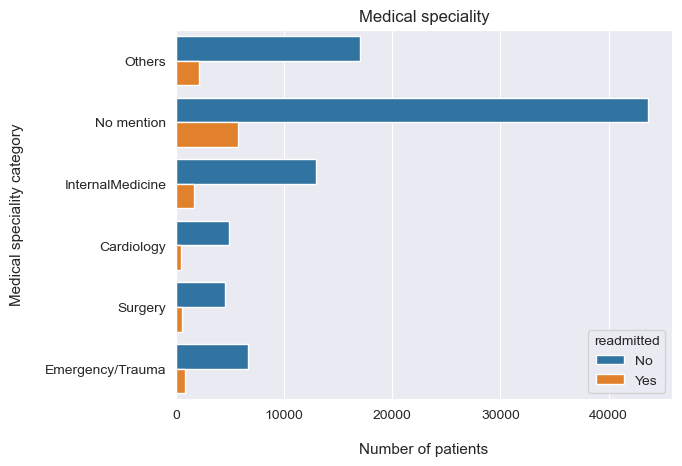

In [109]:
sns.countplot(y=df['medical_specialty'],hue=df['readmitted'])
plt.title("Medical speciality")
plt.xlabel("Number of patients",labelpad=15.0,fontsize=11.0)
plt.ylabel("Medical speciality category",labelpad=15.0,fontsize=11.0)
plt.show()

In [110]:
df.admission_type_id.value_counts()

Emergency     53473
Elective      18797
Urgent        18382
No mention     5270
others         5063
Name: admission_type_id, dtype: int64

In [111]:
df.isnull().sum()[df.isnull().sum() > 0]

race            2124
weight         97819
payer_code     40062
diagnosis_1       20
diagnosis_2      356
diagnosis_3     1421
dtype: int64

In [54]:
single_category = df[feature_medicine + drop_list_medicine].nunique()[df[feature_medicine + drop_list_medicine]
                                                     .nunique() == 1].index.tolist()
two_category = df[feature_medicine + drop_list_medicine].nunique()[df[feature_medicine + drop_list_medicine]
                                                     .nunique() == 2].index.tolist()
four_category = df[feature_medicine + drop_list_medicine].nunique()[df[feature_medicine + drop_list_medicine]
                                                     .nunique() == 4].index.tolist()

### Checking for dependency of diagnosis_1, diagnosis_2 & diagnosis_3

In [112]:
df.diagnosis_1.unique()

array(['Diabetes', 'other', 'Neoplasms', 'circulatory', 'Respiratory',
       'Injury', 'Musculoskeletal', 'Digestive', 'Genitourinary', nan],
      dtype=object)

In [113]:
numeric_features = df.select_dtypes(np.number).columns.difference(['encounter_id',
                                                                   'patient_nbr']).tolist()

In [114]:
categories = ['Diabetes', 'other', 'Neoplasms', 'circulatory', 'Respiratory',
       'Injury', 'Musculoskeletal', 'Digestive', 'Genitourinary']

## Diagnosis_1

In [115]:
for feature in df.columns.difference(numeric_features)[:-1]:
    p_value = stats.chi2_contingency(pd.crosstab(df[feature],df['diagnosis_1']))[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    if result == 'Significant':
        print(f"{feature:25s} : {result}")

A1Cresult                 : Significant
admission_source_id       : Significant
admission_type_id         : Significant
age                       : Significant
change                    : Significant
chlorpropamide            : Significant
diabetesMed               : Significant
diagnosis_1               : Significant
diagnosis_2               : Significant
diagnosis_3               : Significant
discharge_disposition_id  : Significant
gender                    : Significant
glimepiride               : Significant
glipizide                 : Significant
glyburide                 : Significant
glyburide-metformin       : Significant
insulin                   : Significant
max_glu_serum             : Significant
medical_specialty         : Significant
metformin                 : Significant
metformin-pioglitazone    : Significant
nateglinide               : Significant
patient_nbr               : Significant
payer_code                : Significant
pioglitazone              : Significant


In [116]:
for feature in df.columns.difference(numeric_features)[:-1]:
    p_value = stats.chi2_contingency(pd.crosstab(df[feature],df['diagnosis_2']))[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    if result == 'Significant':
        print(f"{feature:25s} : {result}")

A1Cresult                 : Significant
admission_source_id       : Significant
admission_type_id         : Significant
age                       : Significant
change                    : Significant
chlorpropamide            : Significant
diabetesMed               : Significant
diagnosis_1               : Significant
diagnosis_2               : Significant
diagnosis_3               : Significant
discharge_disposition_id  : Significant
gender                    : Significant
glimepiride               : Significant
glipizide                 : Significant
glyburide                 : Significant
glyburide-metformin       : Significant
insulin                   : Significant
max_glu_serum             : Significant
medical_specialty         : Significant
metformin                 : Significant
patient_nbr               : Significant
payer_code                : Significant
pioglitazone              : Significant
race                      : Significant
readmitted                : Significant


In [117]:
for feature in df.columns.difference(numeric_features)[:-1]:
    p_value = stats.chi2_contingency(pd.crosstab(df[feature],df['diagnosis_3']))[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    if result == 'Significant':
        print(f"{feature:25s} : {result}")

A1Cresult                 : Significant
admission_source_id       : Significant
admission_type_id         : Significant
age                       : Significant
change                    : Significant
diabetesMed               : Significant
diagnosis_1               : Significant
diagnosis_2               : Significant
diagnosis_3               : Significant
discharge_disposition_id  : Significant
gender                    : Significant
glimepiride               : Significant
glipizide                 : Significant
glyburide                 : Significant
glyburide-metformin       : Significant
insulin                   : Significant
max_glu_serum             : Significant
medical_specialty         : Significant
metformin                 : Significant
patient_nbr               : Significant
payer_code                : Significant
pioglitazone              : Significant
race                      : Significant
readmitted                : Significant
repaglinide               : Significant


In [118]:
for feature in numeric_features:
    annova = []
    for category in categories:
        annova.append(df[df['diagnosis_1'] == category][feature].values)
    p_value = stats.f_oneway(*annova)[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    print(f"{feature:25s} : {result}")
    annova = []

num_lab_procedures        : Significant
num_medications           : Significant
num_procedures            : Significant
number_diagnoses          : Significant
number_emergency          : Significant
number_inpatient          : Significant
number_outpatient         : Significant
time_in_hospital          : Significant


## Diagnosis_2

In [119]:
categories = ['Diabetes', 'other', 'Neoplasms', 'circulatory', 'Respiratory',
       'Injury', 'Musculoskeletal', 'Digestive', 'Genitourinary']

for feature in numeric_features:
    annova = []
    for category in categories:
        annova.append(df[df['diagnosis_2'] == category][feature].values)
    p_value = stats.f_oneway(*annova)[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    print(f"{feature:25s} : {result}")
    annova = []

num_lab_procedures        : Significant
num_medications           : Significant
num_procedures            : Significant
number_diagnoses          : Significant
number_emergency          : Significant
number_inpatient          : Significant
number_outpatient         : Significant
time_in_hospital          : Significant


## Diagnosis_3

In [120]:
categories = ['Diabetes', 'other', 'Neoplasms', 'circulatory', 'Respiratory',
       'Injury', 'Musculoskeletal', 'Digestive', 'Genitourinary']

for feature in numeric_features:
    annova = []
    for category in categories:
        annova.append(df[df['diagnosis_3'] == category][feature].values)
    p_value = stats.f_oneway(*annova)[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    print(f"{feature:25s} : {result}")
    annova = []

num_lab_procedures        : Significant
num_medications           : Significant
num_procedures            : Significant
number_diagnoses          : Significant
number_emergency          : Significant
number_inpatient          : Significant
number_outpatient         : Significant
time_in_hospital          : Significant


### `Preparing Data for Imputation`

In [121]:
encoder_diagnosis = LabelEncoder()
encoder_race = LabelEncoder()
encoder_diagnosis.fit(df['diagnosis_1'])
encoder_race.fit(df['race'])


mask = df[['diagnosis_1','diagnosis_2',
                'diagnosis_3','race']].isnull()

diagnosis = df[['diagnosis_1','diagnosis_2',
                'diagnosis_3','race']].apply(lambda x : encoder_diagnosis.fit_transform(x) if 'diagnosis' in x else 
                                             encoder_race.fit_transform(x))

diagnosis = diagnosis.where(~mask,df[['diagnosis_1','diagnosis_2',
                                      'diagnosis_3','race']])

numeric = df[numeric_features]
diagnosis_impute = pd.concat([diagnosis,numeric],axis=1)


for i in diagnosis_impute:
    print(f"{i:20s}",diagnosis_impute[i].isnull().sum())

diagnosis_1          20
diagnosis_2          356
diagnosis_3          1421
race                 2124
num_lab_procedures   0
num_medications      0
num_procedures       0
number_diagnoses     0
number_emergency     0
number_inpatient     0
number_outpatient    0
time_in_hospital     0


In [ ]:
# link_race = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Encoder_race.pickle'
# link_diagnosis = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Encoder_diagnosis.pickle'

In [122]:
# for link,encoder in zip([link_race,link_diagnosis],[encoder_race,encoder_diagnosis]):
    # with open(link,'wb') as tr:
        # pickle.dump(encoder,tr)

In [ ]:
from sklearn.experimental.enable_iterative_imputer import IterativeImputer
iterative_impute = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=7,
                                                                   weights='distance'),
                                    n_nearest_features=8,
                                    initial_strategy='most_frequent')

In [ ]:
imputed = iterative_impute.fit_transform(diagnosis_impute) 

In [ ]:
# Pickling the imputer

# link = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Iterative_imputer.pickle'

# import pickle
# with open(link,'wb') as imp:
   # pickle.dump(imputed,imp)

In [ ]:
for i in range(4):
    print("Number of unique values : ",len(np.unique(imputed[:,i])))

In [ ]:
imputed.shape

In [ ]:
temp = pd.DataFrame(data=imputed[:,[0,1,2,3]].astype(int),
                                 columns=['diagnosis_1','diagnosis_2',
                                          'diagnosis_3','race'])
final = pd.DataFrame(columns=['diagnosis_1','diagnosis_2','diagnosis_3','race'])

for column in ['diagnosis_1','diagnosis_2','diagnosis_3','race']:
    if column != 'race':
        final[column] = encoder_diagnosis.inverse_transform(temp[column])
    if column == 'race':
        final[column] = encoder_race.inverse_transform(temp[column])

imputed_diagnosis_df = final.copy()

In [ ]:
imputed_diagnosis_df.isnull().sum()

In [ ]:
imputed_diagnosis_df.shape

In [ ]:
diagnosis_imputed = pd.concat([imputed_diagnosis_df,diagnosis_impute[patient_info_numeric].reset_index(drop=True)],axis=1)

In [ ]:
diagnosis_imputed.isnull().sum()

In [ ]:
diagnosis_imputed.shape

In [ ]:
Imputed_full_data = diagnosis_imputed.copy()

In [ ]:
Imputed_full_data.shape

In [ ]:
Fully_Imputed_data = df.copy()

In [ ]:
Fully_Imputed_data.shape

In [ ]:
Fully_Imputed_data[['diagnosis_1','diagnosis_2','diagnosis_3','race']+patient_info_numeric] = Imputed_full_data

In [ ]:
feature_shuffle_full = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty',
       'diagnosis_1', 'diagnosis_2', 'diagnosis_3',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses',
                        'readmitted']

In [ ]:
Fully_Imputed_data_new = Fully_Imputed_data[feature_shuffle_full]

In [ ]:
link = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Fully_finally_imputed_data.csv'
Fully_Imputed_data_new.to_csv(link)

### `Preparing data for Tree and Ensemble`

### `dropping 7 medicine attributes + 4 patient information`

In [ ]:
df_tree = Fully_Imputed_data.copy()

In [ ]:
print("-"*30)
print("Attributes to be removed")
print("-"*30)
print(*drop_list_patient_info,*drop_list_medicine,sep='\n')
print("-"*30)

In [ ]:
df_tree = df_tree.drop(columns=drop_list_patient_info+drop_list_medicine)

In [ ]:
df_tree.shape

## `Data Preparation (Encoding for Decision_Tree, KNN)`

### `Different encoding for different independent categories`

In [ ]:
patient_info = ['race', 'gender', 'age', 'admission_type_id',
                'discharge_disposition_id','admission_source_id',
                'medical_specialty','diagnosis_1','diagnosis_2', 'diagnosis_3',
                'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

# Features which contains no information
drop_list_patient_info = ['encounter_id','patient_nbr','weight','payer_code']

# Numeric features
patient_info_numeric = ['time_in_hospital','num_lab_procedures',
                        'num_procedures','num_medications',
                        'number_outpatient','number_emergency',
                        'number_inpatient','number_diagnoses']

# Taking initial decision to keep 16 features
feature_medicine = ['metformin','repaglinide', 'nateglinide', 
                     'chlorpropamide', 'glimepiride', 'glipizide', 
                     'glyburide', 'tolbutamide','pioglitazone',
                     'rosiglitazone', 'acarbose', 'miglitol','tolazamide',
                     'insulin','glyburide-metformin', 'glipizide-metformin']

# Initial decision to remove 7 features
drop_list_medicine = ['acetohexamide','troglitazone','examide','citoglipton',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']


# The medicines which contains 'Steady' & 'No' for encoding purpose
two_category_medicine = ['acetohexamide', 'tolbutamide', 'troglitazone',
                         'glipizide-metformin', 'glimepiride-pioglitazone',
                         'metformin-rosiglitazone', 'metformin-pioglitazone']
# ------------------------------------------------------------------
# The medicines which contains 'Steady','Up','Down' & 'No' for encoding purpose (14)
four_category_medicine = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                          'glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone',
                          'acarbose','miglitol','tolazamide','insulin','glyburide-metformin'] 
# ------------------------------------------------------------------
# considering these two medicines with only 'steady' & 'No' categories for encoding purpose
two_category_medicine_to_be_kept = ['tolbutamide','glipizide-metformin']
# ------------------------------------------------------------------                                                
# Out of initial removal decision, these 2 are compulsorily removed.
single_category_medicine = ['examide', 'citoglipton']
                                             

print(set(drop_list_medicine) & set(two_category_medicine))

dependent = 'readmitted'

In [ ]:
# 16 Medicines
Medicine = feature_medicine.copy()
categories_all = [['No','Down','Steady','Up'] for  i in range(len(feature_medicine))]
Medicine_encode = OrdinalEncoder(categories=categories_all)

# 17th feature 
serum = ['max_glu_serum']
serum_encode = OrdinalEncoder(categories=[['None','Norm','>200','>300']])

# 18th feature
HBA1c = ['A1Cresult']
HBA1c_encode = OrdinalEncoder(categories=[['None','Norm','>7','>8']])

# 19th feature
age = ['age']
age_encode = OrdinalEncoder(categories=[df['age'].unique().tolist()])

# 20th 
gender = ['gender']
gender_encode = OrdinalEncoder(categories=[['Female','Male']])

# 18th 
change = ['change']
change_encode = OrdinalEncoder(categories=[['No', 'Ch']])

# 21th
diabetes = ['diabetesMed']
diabetes_encode = OrdinalEncoder(categories=[['No', 'Yes']])

# The 22-29 categorical features in which the levels are independent 

Independent = ['race','medical_specialty','diagnosis_1','diagnosis_2','diagnosis_3',
                   'admission_type_id','discharge_disposition_id','admission_source_id']
Independent_encode = OrdinalEncoder()

# 30-38th feature
# Considering 8 numerical features into consideration
# Total 39 categories considered for Encoding

# 39th feature
Target = ['readmitted']
Target_encode = OrdinalEncoder(categories=[['No','Yes']])

total_transformation = Medicine + serum + HBA1c + age + gender + change + diabetes + Independent + Target

In [ ]:
len(total_transformation+patient_info_numeric)

In [ ]:
# Column transformer with 6 transformations passed

transformation = [('Medicine',Medicine_encode,Medicine),
                  ('Serum',serum_encode,serum),
                  ('HBA1c',HBA1c_encode,HBA1c),
                  ('age',age_encode,age),
                  ('gender',gender_encode,gender),
                  ('change',change_encode,change),
                  ('Diabetes',diabetes_encode,diabetes),
                 ('independent',Independent_encode,Independent),
                 ('Target',Target_encode,Target)]

In [ ]:
# concatenating all data df_KNN(dummy encoding), Transformed data & Target

trf_tree = ColumnTransformer(transformers=transformation,remainder='passthrough')

Tree_Data = trf_tree.fit_transform(df_tree[total_transformation+patient_info_numeric])

In [ ]:
# link_trf = r'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Numeric_Transformer.pickle'

In [ ]:
# import pickle
# with open(link_trf,'wb') as trf:
    # pickle.dump(trf_tree,trf)

In [ ]:
Tree_Data.shape

In [ ]:
len(total_transformation + patient_info_numeric)

In [ ]:
df_tree = pd.DataFrame(Tree_Data,columns=total_transformation + patient_info_numeric)

In [ ]:
# putting target at the last

feature_shuffle = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'max_glu_serum',
       'A1Cresult', 'age', 'gender', 'change', 'diabetesMed', 'race',
       'medical_specialty', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications',
        'number_outpatient','number_emergency', 'number_inpatient', 'number_diagnoses',
        'readmitted']

In [ ]:
Final_data_for_Tree = df_tree[feature_shuffle].astype(int)

In [ ]:
# link1 = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Fully_prepared_data_for_Tree_&_Ensemble.csv'
# Final_data_for_Tree.to_csv(link1)

## `User defined Functions`

In [ ]:
def hold_out_validation_report(fitted_model,X_train,X_test,y_train,y_test):
    
    confusion_mat = confusion_matrix(y_test,fitted_model.predict(X_test))
    
    print(confusion_mat)
    print("-"*50)
    train_accuracy = accuracy_score(y_train,fitted_model.predict(X_train))
    test_accuracy = accuracy_score(y_test,fitted_model.predict(X_test))
    
    print(f"Training Accuracy : {train_accuracy*100:0.2f}")
    print(f"Validation Accuracy : {test_accuracy*100:0.2f}")
    print("-"*50)
    train_precision = precision_score(y_train,fitted_model.predict(X_train))
    test_precision = precision_score(y_test,fitted_model.predict(X_test))
    
    print(f"Precision (Training) : {train_precision*100:0.2f}")
    print(f"Precision (Validation) : {test_precision*100:0.2f}")
    print("-"*50)
    train_recall = recall_score(y_train,fitted_model.predict(X_train))
    test_recall = recall_score(y_test,fitted_model.predict(X_test))
    
    print(f"Recall (Training) : {train_recall*100:0.2f}")
    print(f"Recall (Validation) : {test_recall*100:0.2f}")
    print("-"*50)
    
    train_f1 = f1_score(y_train,fitted_model.predict(X_train))
    test_f1 = f1_score(y_test,fitted_model.predict(X_test)) 
    
    print(f"F1 score (Training) : {train_f1*100:0.2f}")
    print(f"F1 score (validation) : {test_f1*100:0.2f}")
    print("-"*50)
    
    train_baccuracy = balanced_accuracy_score(y_train,fitted_model.predict(X_train))
    test_baccuracy = balanced_accuracy_score(y_test,fitted_model.predict(X_test))
    
    print(f"Balanced Accuracy (Training): {train_accuracy*100:0.2f}")
    print(f"Balanced Accuracy (Validation): {test_accuracy*100:0.2f}")

In [ ]:
def features_selector_model(model,features,Target):
    X_tr, X_ts, y_tr, y_ts = train_test_split(features,Target,test_size=0.20, random_state=55)
    model.fit(X_tr,y_tr)
    confusion_mat = confusion_matrix(y_ts,model.predict(X_ts))
    print(confusion_mat)
    print("-"*50)
    train_accuracy = accuracy_score(y_tr,model.predict(X_tr))
    test_accuracy = accuracy_score(y_ts,model.predict(X_ts))
    
    print(f"Training Accuracy : {train_accuracy*100:0.2f}")
    print(f"Validation Accuracy : {test_accuracy*100:0.2f}")
    print("-"*50)
    train_precision = precision_score(y_tr,model.predict(X_tr))
    test_precision = precision_score(y_ts,model.predict(X_ts))
    
    print(f"Precision (Training) : {train_precision*100:0.2f}")
    print(f"Precision (Validation) : {test_precision*100:0.2f}")
    print("-"*50)
    train_recall = recall_score(y_tr,model.predict(X_tr))
    test_recall = recall_score(y_ts,model.predict(X_ts))
    
    print(f"Recall (Training) : {train_recall*100:0.2f}")
    print(f"Recall (Validation) : {test_recall*100:0.2f}")
    print("-"*50)
    
    train_f1 = f1_score(y_tr,model.predict(X_tr))
    test_f1 = f1_score(y_ts,model.predict(X_ts)) 
    
    print(f"F1 score (Training) : {train_f1*100:0.2f}")
    print(f"F1 score (validation) : {test_f1*100:0.2f}")
    print("-"*50)
    
    train_baccuracy = balanced_accuracy_score(y_tr,model.predict(X_tr))
    test_baccuracy = balanced_accuracy_score(y_ts,model.predict(X_ts))
    
    print(f"Balanced Accuracy (Training): {train_accuracy*100:0.2f}")
    print(f"Balanced Accuracy (Validation): {test_accuracy*100:0.2f}")

In [ ]:
def cv_report(model,features=None,Target=None):
    Scv = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)
    X_tr, X_ts, y_tr, y_ts = train_test_split(features,Target,test_size=0.20, random_state=102)
    model.fit(X_tr,y_tr)
    confusion_mat = confusion_matrix(y_ts,model.predict(X_ts))
    cv_accuracy = cross_val_score(model,X_tr,y_tr,cv=Scv,scoring='accuracy').mean()
    print(f"Cross validation Accuracy : {cv_accuracy*100:0.2f}")
    print("-"*50)
    cv_precison = cross_val_score(model,X_tr,y_tr,cv=Scv,scoring='precision').mean()
    print(f"Cross validation Precision : {cv_precison*100:0.2f}")
    print("-"*50)
    cv_recall = cross_val_score(model,X_tr,y_tr,cv=Scv,scoring='recall').mean()
    print(f"Cross validation Recall : {cv_recall*100:0.2f}")
    print("-"*50)
    cv_f1 = cross_val_score(model,X_tr,y_tr,cv=Scv,scoring='f1').mean()
    print(f"Cross validation f1 : {cv_f1*100:0.2f}")